# 01-LL_findHomologs

In [1]:
from Bio.Blast import NCBIWWW
from Bio.Seq import Seq
from Bio import SeqIO
blast = True
import pathlib
from Bio.Blast import NCBIXML

### Intro

This notebook is made to be able to find homologs from protein queries. As a **test case** the SLS step in the Strictosidine pathway was chosen.  

**Some background on Strictosidine:** 
Strictosidine is a precurser for several anti-cancer compounds and is interesting because it is extracted from plants and due to weather and agricultural pests yields vary year to year (Brown et al., 2015). Additionally, Strictosidine is difficult to chemically synthesisze. These  therefore we therefore want to take the prouction  to a yeast cell factory. However, the SLS (SLS_reductase) part of the pathway is the limiting step of the pathway and we want to optimize that via combinatorial optimizition. We have therefore chosen this step as test case for developing algorithms that can standardize homolog selection. The pathway is shown below.

This notebook has been developed to answer the following question:

**Can we via algorithms determine and standardize homolog selection?** 



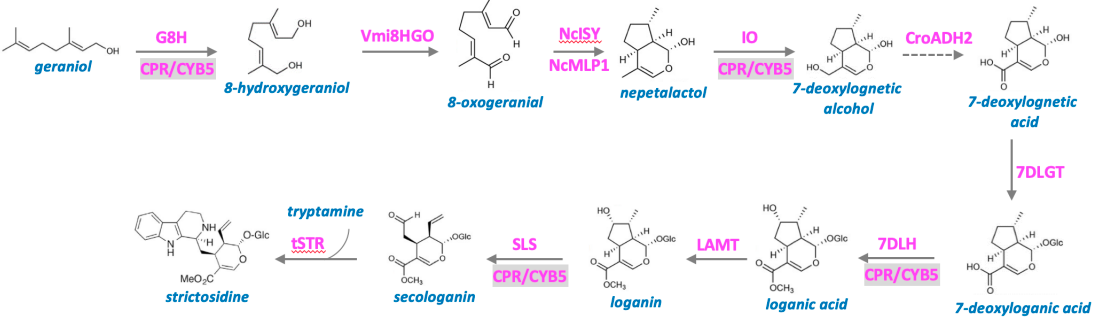

In [2]:
from IPython import display
display.Image('Pictures/Strictosidine_pathway.png')

**Main objective:**

- Finding Homologs for SLS, a major bottleneck in the Strictosidine pathway. More specifically two groups: 
    - SLS-CYP (Cytochrome p450)
    - SLS-CPR (Cytochrome p450 reductase)
    

**The method/algorithm for finding the set of homologs is described as follows:**

1. Read in the protein sequence of interest
2. BLAST the sequence with the Biopython NCBIWWW.qblast function and select “blastp”. 
3. Search through the newly generated alignment XML file and find proteins that fit your parameters and save ACC numbers. Parameters included here are: 
    - Identity: 70-95% 
    - E-value threshold 0.04
4. The ACC numbers are then used for fetching the protein sequences and saved as a FASTA file. 
5. The protein sequences are then made into DNA sequences in a 2 step process.
6. A temporary DNA sequence is made from a translation table
7. Codon optimized with “DNA chisel” for the organism of choice.
8. The codon-optimized sequences are made into Biopython SeqRecord objects and can be: 
    - Exported to a database of choice through an API (Benchling, Teselagen)
    - Saved as a FASTA file. 


#### First we make a file path for the fasta file we want to blast

In [3]:
p = 'Data/Protein_sequence_data/CroSLS1AA.fa'
pathCroSLS1 = pathlib.Path(p).resolve()
pathCroSLS1

PosixPath('/home/lucas/projects/SLS_library/Notebooks/Data/Protein_sequence_data/CroSLS1AA.fa')

#### Then we read it into a Seqrecord object with biopython

In [4]:
croSLS1 = SeqIO.read(pathCroSLS1, format="fasta")
croSLS1

SeqRecord(seq=Seq('MEMDMDIIRKAIAATIFALVMAWAWRVLDWAWFTPKRIEKRLRQQGFRGNPYRF...NF*'), id='CroSLS1', name='CroSLS1', description='CroSLS1', dbxrefs=[])

### Blasting it on NCBI

In [5]:
%%time
result_handle = NCBIWWW.qblast("blastp", "nr", sequence=croSLS1) # format_type='Text',

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 1min 8s


#### Write the blast onto a file and close the results 

In [6]:
blast_result = open("Data/Homolog_data_files/SLS_homologs.xml", "w")
blast_result.write(result_handle.read())
blast_result.close()
result_handle.close()

#### THen open the generated file and read it into a variable 

In [7]:
from Bio.Blast import NCBIXML

with open("Data/Homolog_data_files/SLS_homologs.xml", "r") as result_handle:
    blast_record = NCBIXML.read(result_handle)

#### Filter BLAST results, on E-value, percentage protein identity - Here I chose 0.7 - 0.95 

In [8]:
E_VALUE_THRESH = 0.04
LOWER_PROTEIN_IDENTITY_THRESH = 0.70
UPPER__PROTEIN_IDENTITY_THRESH = 0.95
Alignments_that_follow_our_criteria = [] #These are the ACC numbers

# saving some of the metrics
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/ hsp.align_length)
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH:
            counter += 1
            print("\nAlignment#", counter)
            print("Name:", alignment.hit_def)
            print("Title:", alignment.title)
            print("Length:", alignment.length)
            print("E value:", hsp.expect)
            print('Query:', hsp.query[0:75] + "...")
            print('Match:', hsp.match[0:75] + "...")
            print('Subjt:',hsp.sbjct[0:75] + "...")
            print('Identitiy', "{:.2f}".format(IDENTITY))
            print(alignment)
            
            # Saving the metrics we want into different lists
            Alignments_that_follow_our_criteria.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


Alignment# 1
Name: secologanin synthase-like protein 4 [Catharanthus roseus]
Title: gb|AKF02530.1| secologanin synthase-like protein 4 [Catharanthus roseus]
Length: 524
E value: 1.82179e-28
Query: MEMDMDIIRKAIAATIFALVMAWAWRVLDWAWFTPKRIEKRLRQQGFRGNPYRF...
Match: ME DMD IRKAIAATI ALVMAWAWRVLDWAWFTPKRIEKRLRQQGFRGNPYRF...
Subjt: MEKDMDTIRKAIAATILALVMAWAWRVLDWAWFTPKRIEKRLRQQGFRGNPYRF...
Identitiy 0.94
gb|AKF02530.1| secologanin synthase-like protein 4 [Catharanthus roseus]
           Length = 524


Alignment# 2
Name: cytochrome P450 [Catharanthus roseus] >gb|AKF02529.1| secologanin synthase-like protein 3 [Catharanthus roseus]
Title: gb|AAA17732.1| cytochrome P450 [Catharanthus roseus] >gb|AKF02529.1| secologanin synthase-like protein 3 [Catharanthus roseus]
Length: 524
E value: 2.16297e-28
Query: MEMDMDIIRKAIAATIFALVMAWAWRVLDWAWFTPKRIEKRLRQQGFRGNPYRF...
Match: MEMDM  IRKAIAATIFALV+AWAWRVLDWAWFTPKRIEKRLRQQGFRGNPYRF...
Subjt: MEMDMYTIRKAIAATIFALVVAWAWRVLDWAWFTPKRIEKRLRQQGFRGNPYRF...
Identit

We can add the alignments into a dataframe

In [9]:
import pandas as pd

In [30]:
pd.set_option('display.max_colwidth', None)

In [31]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])

,Name,Identity,E_value,Length,ACC_number
0,secologanin synthase-like protein 4 [Catharanthus roseus],0.944444,1.821790e-28,524,AKF02530
1,cytochrome P450 [Catharanthus roseus] >gb|AKF02529.1| secologanin synthase-like protein 3 [Catharanthus roseus],0.944444,2.162970e-28,524,AAA17732
2,secologanin synthase-like protein [Amsonia hubrichtii],0.870370,3.002680e-27,524,AGX93046
3,secologanin synthase-like protein [Rauvolfia serpentina],0.870370,3.182130e-26,524,AGX93047
4,secologanin synthase-like protein [Vinca minor],0.777778,5.863780e-24,524,AGX93049
5,secologanin synthase 1 [Ophiorrhiza pumila],0.777778,3.163380e-21,522,QWX38536
6,"secologanin synthase-like protein, partial [Cinchona calisaya]",0.820000,3.774760e-21,518,AGX93045
7,secologanin synthase [Ophiorrhiza pumila],0.769231,8.560980e-20,520,BAP90521
8,secologanin synthase 3 [Ophiorrhiza pumila],0.711538,6.177770e-17,521,QWX38538
9,secologanin synthase-like protein [Tabernaemontana elegans],0.833333,1.839780e-12,524,AGX93048


#### The alignments are saved onto a Bio.Blast.Record.Alignment datatype

In [32]:
Alignments_that_follow_our_criteria[0].hit_def

'secologanin synthase-like protein 4 [Catharanthus roseus]'

### To get acc numbers and descriptions

In [33]:
acc_numbers = []
Names_species = []
# print(Alignments_that_follow_our_criteria[0].identities)
for alignment in Alignments_that_follow_our_criteria:
    acc_numbers.append(alignment.accession)
    Names_species.append(alignment.hit_def)
    
len(acc_numbers)

10

## Retrieve the sequences and write them onto a file

### Getting DNA sequences through Entrez 

Retrieve the sequences with the Entrez library which is possible with the ACC numbers we found before. Save the retrieved sequences as a fasta file called 'Homolog_seqs.fasta'. You need to provide an email for this so they know who you are. 

In [34]:
from Bio import Entrez

In [35]:
%%time

email = "lucaslevassor@gmail.com"

out_handle = open('Data/Homolog_data_files/SLS_CYP_Homolog_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
out_handle.close()

CPU times: user 181 ms, sys: 13.3 ms, total: 195 ms
Wall time: 7.25 s


### Read the sequences into variables

Now parse through the file and get all the AA sequences which can be made into to DNA later. 

In [36]:
fasta_sequences = SeqIO.parse(open('Data/Homolog_data_files/SLS_CYP_Homolog_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    sequences.append(str(sequence)+'*')
    

## Codon optimize it for yeast

In [37]:
from collections import Counter
from synbiopython.codon import table, taxonomy_utils, utils
from random import *

### We can use the synbiopython translation table

In [38]:
name = taxonomy_utils.get_organism_name(4932)
tax_id = taxonomy_utils.get_tax_id("Saccharomyces cerevisiae")

print("Name:", name)
print("Taxonomy id:", tax_id)

Name: Saccharomyces cerevisiae
Taxonomy id: 4932


In [39]:
name_table = table.get_table(name)
tax_id_table = table.get_table(tax_id)

In [40]:
assert name_table == tax_id_table

In [41]:
def sample1(table, amino_acid):
    """I HAVE BEEN PLAYING AROUND WITH THIS FUNCTION
    Have changed the cum_freq
    """
    cum_freq = 0.69

    # the higest frequency in any S.c codon is 0.69
    rand_val = random()

    for codon, freq in table[amino_acid].items():
        cum_freq += freq

        if cum_freq > rand_val:
            return codon

    return None


def optimise(table, aa_seq):
    """Codon optimise an amino acid sequence.

    :param table: a codon usage table.
    :type table: dict
    :param aa_seq: an amino acid sequence.
    :type table: str
    :return: a codon-optimised nucleic acid sequence, encoding the supplied
        amino acid sequence
    :rtype: str
    """
    return ''.join([sample1(table, amino_acid) for amino_acid in aa_seq])

THIS is how synbiopython selects codon - based on random.random

### Now for making codon_optimized DNA from our protein sequences: 

In [42]:
### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(optimise(name_table, aa_seq))
len(protein_to_dna)

10

### DNA chisel

Here the DNA is codon optimized with DNA chisel

In [43]:
### Using DNA chisel to optimize the pattern: 

from dnachisel import *

codon_optimized_seqs = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
        sequence=protein_to_dna[i], 
        constraints=[EnforceGCContent(mini=0.3, maxi=0.7)],
        objectives=[CodonOptimize(species='s_cerevisiae')]
    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = 'SLS{}'.format(i)
    final_record.description = Names_species[i]
    
    codon_optimized_seqs.append(final_record)

location: 100%|██████████| 487/487 [00:00<00:00, 1992.78it/s, now=1074-1077]


In [44]:
codon_optimized_seqs

[SeqRecord(seq=Seq('ATGGATAATGAAATGGAAACTATGCCAAATGCTATGGCTGCTACTATGCCAGCT...TAT'), id='AKF02530', name='SLS0', description='secologanin synthase-like protein 4 [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATATGGAAATGTAAACTATGCCAAATGCTATGGCTGCTACTATGTTGGCT...TAT'), id='AAA17732', name='SLS1', description='cytochrome P450 [Catharanthus roseus] >gb|AKF02529.1| secologanin synthase-like protein 3 [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATATGGAAATGGAAATGATGCCAAATGCTATGGCTGCTTCTGTTTTGGCT...TAT'), id='AGX93046', name='SLS2', description='secologanin synthase-like protein [Amsonia hubrichtii]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATATGGAAATGGAAACTATGCCAAATGCTATGGCTACTGCTGTTTTGGCT...TAT'), id='AGX93047', name='SLS3', description='secologanin synthase-like protein [Rauvolfia serpentina]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATATGGAAATGGAAACTATGCCAAATACTATGGCTACTACTGTTTTGATG...TAT'), id='AGX93049', name='SLS4', description='secologanin synthase-like protein

Writing the sequences into a fasta_file

In [45]:
with open('Data/Homolog_data_files/SLS_CYP_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs)):
        print(codon_optimized_seqs[i].format("fasta"), file = outfile)

<!-- My_api_key:

4772e3e5-57ce-4b75-a3a8-06c49a2e202d -->

# Now for the SLS CPR 

- The CPR was found in the article: De novo production of the plant-derived alkaloid strictosidine in yeast, under suplementary information
- From the fasta-file we have the CPR protein sequece and then we can repeat what was done above for finding SLS homologs 

In [46]:
SLS_CPR = SeqIO.read('Data/Protein_sequence_data/Q05001SLS_cpr.fasta', format="fasta")
SLS_CPR

SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...VW*'), id='sp|Q05001|NCPR_CATRO', name='sp|Q05001|NCPR_CATRO', description='sp|Q05001|NCPR_CATRO NADPH--cytochrome P450 reductase OS=Catharanthus roseus OX=4058 GN=CPR PE=2 SV=1', dbxrefs=[])

In [47]:
print(SLS_CPR.seq)

MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILTTSVAVLIGCVVVLIWRRSSGSGKKVVEPPKLIVPKSVVEPEEIDEGKKKFTIFFGTQTGTAEGFAKALAEEAKARYEKAVIKVIDIDDYAADDEEYEEKFRKETLAFFILATYGDGEPTDNAARFYKWFVEGNDRGDWLKNLQYGVFGLGNRQYEHFNKIAKVVDEKVAEQGGKRIVPLVLGDDDQCIEDDFAAWRENVWPELDNLLRDEDDTTVSTTYTAAIPEYRVVFPDKSDSLISEANGHANGYANGNTVYDAQHPCRSNVAVRKELHTPASDRSCTHLDFDIAGTGLSYGTGDHVGVYCDNLSETVEEAERLLNLPPETYFSLHADKEDGTPLAGSSLPPPFPPCTLRTALTRYADLLNTPKKSALLALAAYASDPNEADRLKYLASPAGKDEYAQSLVANQRSLLEVMAEFPSAKPPLGVFFAAIAPRLQPRFYSISSSPRMAPSRIHVTCALVYEKTPGGRIHKGVCSTWMKNAIPLEESRDCSWAPIFVRQSNFKLPADPKVPVIMIGPGTGLAPFRGFLQERLALKEEGAELGTAVFFFGCRNRKMDYIYEDELNHFLEIGALSELLVAFSREGPTKQYVQHKMAEKASDIWRMISDGAYVYVCGDAKGMARDVHRTLHTIAQEQGSMDSTQAEGFVKNLQMTGRYLRDVW*


In [54]:
%%time
result_handle1 = NCBIWWW.qblast("blastp", "nr", sequence = SLS_CPR.seq)

CPU times: user 220 ms, sys: 8.65 ms, total: 229 ms
Wall time: 3min 3s


#### We write the blast onto a file so and close the results 

In [55]:
blast_result1 = open("Data/Homolog_data_files/SLS_CPR_homologs.xml", "w")
blast_result1.write(result_handle1.read())
blast_result1.close()
result_handle1.close()

#### THen we open the generated file and read it into a variable 

In [56]:
from Bio.Blast import NCBIXML

with open("Data/Homolog_data_files/SLS_CPR_homologs.xml", "r") as result_handle1:
    blast_record = NCBIXML.read(result_handle1)

#### We can select the blast resulst we want on E-value and upper and lower percentage protein identity we want - Here we chose 0.7 - 0.95 

In [57]:
E_VALUE_THRESH = 0.04
LOWER_PROTEIN_IDENTITY_THRESH = 0.76
UPPER__PROTEIN_IDENTITY_THRESH = 0.95
AA_length_min = 704
AA_length_max = 724
Alignments_that_follow_our_criteria1 = []

# saving some of the metrics
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/ hsp.align_length)
        LENGTH = alignment.length 
        # We add the added reqirement that the sequence should be +-10 amino acids 
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH and LENGTH > AA_length_min and LENGTH<AA_length_max :
            counter += 1
#             print("\nAlignment#", counter)
#             print("Name:", alignment.hit_def)
#             print("Title:", alignment.title)
#             print("Length:", alignment.length)
#             print("E value:", hsp.expect)
#             print('Query:', hsp.query[0:75] + "...")
#             print('Match:', hsp.match[0:75] + "...")
#             print('Subjt:',hsp.sbjct[0:75] + "...")
#             print('Identitiy', "{:.2f}".format(IDENTITY))
            
            # Saving into different lists
            Alignments_that_follow_our_criteria1.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


TOTAL HOMOLOGS 44


Now we can sort the results in a dataframe 

In [58]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
df_with_SLS_CPR = pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])
df_with_SLS_CPR = df_with_SLS_CPR.sort_values(by=['Identity'])
df_with_SLS_CPR

,Name,Identity,E_value,Length,ACC_number
40,NADPH--cytochrome P450 reductase-like [Salvia splendens] >gb|KAG6427831.1| hypothetical protein SASPL_112078 [Salvia splendens],0.765035,0.0,712,XP_042054710
37,hypothetical protein Vadar_013487 [Vaccinium darrowii],0.770629,0.0,708,KAH7860443
38,NADPH cytochrome P450 reductase [Picrorhiza kurrooa],0.772028,0.0,710,AEW43314
42,NADPH--cytochrome p450 reductase [Phtheirospermum japonicum],0.772664,0.0,712,GFP93273
27,NADPH--cytochrome P450 reductase-like [Cynara cardunculus var. scolymus],0.773743,0.0,709,XP_024960139
21,PREDICTED: NADPH--cytochrome P450 reductase-like [Erythranthe guttata] >gb|EYU20907.1| hypothetical protein MIMGU_mgv1a002097mg [Erythranthe guttata],0.775140,0.0,715,XP_012857359
35,cytochrome P450 oxidoreductase [Ocimum basilicum],0.777622,0.0,707,AGC92176
12,NADPH--cytochrome P450 reductase-like [Salvia splendens] >gb|KAG6430878.1| hypothetical protein SASPL_108951 [Salvia splendens],0.777933,0.0,713,XP_042050280
32,NADPH--cytochrome P450 reductase [Vitis riparia],0.777933,0.0,705,XP_034699648
31,NADPH--cytochrome P450 reductase [Vitis vinifera],0.779330,0.0,705,RVW75508


We get 44 alignments which is a bit much so we will have to narrow it down to make a library of feasible size. 

Lets try to sample every 6 from the sorted dataframe. THat way we get CPRs that have different amino acid identities and reduce the number of parts. 


In [59]:
rate = 6
subset = df_with_SLS_CPR[::rate]
subset

,Name,Identity,E_value,Length,ACC_number
40,NADPH--cytochrome P450 reductase-like [Salvia splendens] >gb|KAG6427831.1| hypothetical protein SASPL_112078 [Salvia splendens],0.765035,0.0,712,XP_042054710
35,cytochrome P450 oxidoreductase [Ocimum basilicum],0.777622,0.0,707,AGC92176
14,NADPH--cytochrome P450 reductase-like [Ipomoea triloba],0.780420,0.0,709,XP_031108978
28,NADPH-cytochrome P450 reductase [Ocimum basilicum],0.783217,0.0,710,ANW46529
29,MFS transporter multidrug-resistance type transporter [Datura stramonium],0.788595,0.0,715,MCD9641443
24,NADPH:cytochrome P450 reductase [Scoparia dulcis],0.797486,0.0,713,AGX85599
26,cytochrome P450 NADPH-reductase [Petunia x hybrida],0.802503,0.0,715,AAZ39649
1,NADPH--cytochrome P450 reductase-like [Coffea arabica],0.837535,0.0,712,XP_027072686


In [60]:
acc_numbers = subset['ACC_number'].tolist()
acc_numbers

['XP_042054710',
 'AGC92176',
 'XP_031108978',
 'ANW46529',
 'MCD9641443',
 'AGX85599',
 'AAZ39649',
 'XP_027072686']

Now we blast we get all the sequences from the accession numbers

In [62]:
%%time

email = "lucaslevassor@gmail.com"

out_handle = open('Data/Homolog_data_files/SLS_CPR_homolog_protein_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
    
out_handle.close()

CPU times: user 186 ms, sys: 8.81 ms, total: 195 ms
Wall time: 5.94 s


### Read in the sequences into variables


Now we can parse through the file and get all the AA sequences which we can make to DNA later. 

In [63]:
fasta_sequences = SeqIO.parse(open('Data/Homolog_data_files/SLS_CPR_homolog_protein_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    sequences.append(str(sequence)+'*')
    

## Codon optimize it for yeast

We can do the same as before of first making a dummy dna sequence with the use of the synbiopython translation table

In [64]:
### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(optimise(name_table, aa_seq))


### Now for making codon_optimized DNA from our protein sequences:  DNA chisel

In [65]:
### Using DNA chisel to optimize the pattern: 

from dnachisel import *

codon_optimized_seqs1 = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
        sequence=protein_to_dna[i], 
        constraints=[EnforceGCContent(mini=0.3, maxi=0.7)],
        objectives=[CodonOptimize(species='s_cerevisiae')]
    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = 'SLS_CPR {}'.format(i)
    final_record.description = Names_species[i]
    
    codon_optimized_seqs1.append(final_record)

location: 100%|██████████| 685/685 [00:00<00:00, 1826.99it/s, now=1662-1665]


In [66]:
codon_optimized_seqs1

[SeqRecord(seq=Seq('ATGGATTCTACTTCTGATAATCCATCTCCATTGGAATTGATGACTGCTATGTTG...TAT'), id='XP_042054710', name='SLS_CPR 0', description='secologanin synthase-like protein 4 [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATCCAACTTCTCATAATCCATCTCCACCAGAATTGATGGCTGCTATGCCA...TAT'), id='AGC92176', name='SLS_CPR 1', description='cytochrome P450 [Catharanthus roseus] >gb|AKF02529.1| secologanin synthase-like protein 3 [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATCCAACTTCTGATAATCCATCTCCATTGGAATTGATGGCTGCTATGTTG...TAT'), id='XP_031108978', name='SLS_CPR 2', description='secologanin synthase-like protein [Amsonia hubrichtii]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTCTACTTCTGATAATCCATCTCCATTGGAATTGATGACTGCTATGCCA...TAT'), id='ANW46529', name='SLS_CPR 3', description='secologanin synthase-like protein [Rauvolfia serpentina]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGAATCTACTAGAGATAATCCATCTCCATTGGAATTGATGGCTGCTATGTTG...TGG'), id='MCD9641443', name='SLS_CPR 4', description

Writing the sequences into a fasta_file

In [67]:
with open('Data/Homolog_data_files/SLS_CPR_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs1)):
        print(codon_optimized_seqs1[i].format("fasta"), file = outfile)

## Does the the SLS_CYP and SLS_CPR share too much homology? 

One way to figure this out is to use the Clustal Omega online tool: https://www.ebi.ac.uk/Tools/msa/clustalo/

1. Upload fasta file with all sequences
2. THis was done and a lot of homology was found between the SLS CPR and CYP. This information can be found in the files folder


We can present the result visually as a phylogenetic tree as shown below.

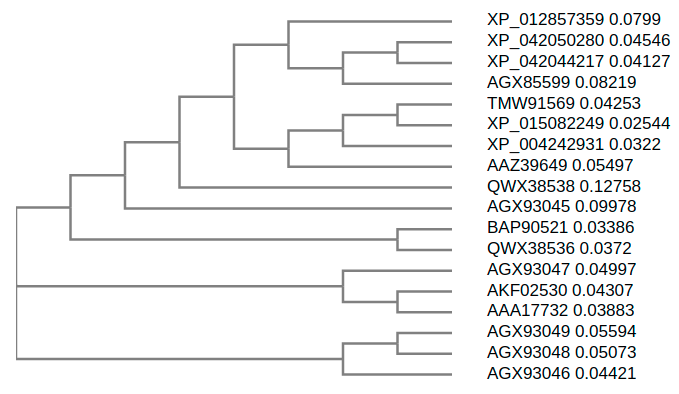

In [68]:
display.Image('Pictures/PHYLO_CYP_CPR.png')

Here it is clear that the CYPs and CPRs are clustered into their own clades. However, when looking closely at the clustal omega file there are found streches of DNA that show homology which could be a problem for integration. 

This problem could be alliviated by:
1. Integrateting the CYPs and CPRs seperately in different genomic locations. 
2. Changing the parameters of the Codon optimization in either the CYP step or the CPR step, or constraing DNA chisel to avoid the same sequences. DNA chisel has the UniquifyAllKmers to do this. 

### Conclusion 

- 10 SLS CYPs were found and codon-optimized
- 8 CPRs were found and codon-optimized

## References: 
    
    
    

Brown, S., Clastre, M., Courdavault, V. and O’Connor, S., 2015. De novo production of the plant-derived alkaloid strictosidine in yeast. Proceedings of the National Academy of Sciences, 112(11), pp.3205-3210.